In [1]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

In [2]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesDColor = ['#6a0e03','#1d4c44','#183649']
speciesNames = ['monkey','human','human2']

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################

analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)


categoryNames = ['Perseveration',
                 'Random search',
                 'Rule random, \n Exploration',
                 'Rule favored, \n Exploration',
                 'Rule preferred, \n No exploration',
                 'Rule persist, \n No exploration']

subjectNames = ['1','2','3','4','1','2','3','4','5','1','2','3','4','5']


In [3]:
Lc = np.zeros([numSubjects,6])

for i in range(numSubjects):
    Lc[i] = analysis[i]['categoryAnalysis']['meanLCategory']


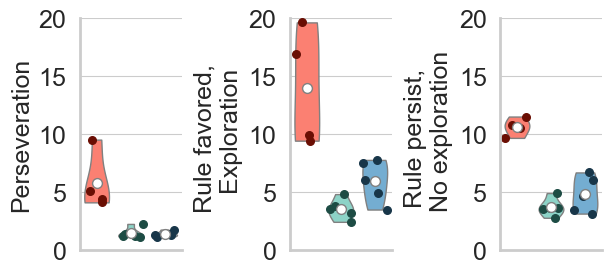

In [9]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(4*1.75,4))
fig.tight_layout(pad=5.0)
vpWidth = 0.4

categories = [0,3,5]
for i in range(3):

    for spInd in range(3): # Species
        idx = np.where(np.array(speciesList) == spInd)[0]

        # monkey
        data1 = Lc[idx,categories[i]]
        x1 = -vpWidth/2*1.1 + spInd*(vpWidth/2*1.1)
        vp1 = ax[i].violinplot(data1,[x1],showextrema=False,widths=0.4*vpWidth)
        for pc in vp1['bodies']:
            pc.set_facecolor(speciesColor[spInd])
            pc.set_edgecolor('gray')
            pc.set_alpha(1)

        x = npr.rand(len(idx)) * (vpWidth) * (0.2)
        pm = getPM(x.shape[0])
        x = np.multiply(x,pm) + x1
        ax[i].scatter(x,data1,s=30,color=speciesDColor[spInd])
        ax[i].set_ylabel(categoryNames[categories[i]],fontsize=18)
        ax[i].scatter(x1,np.mean(data1),color='white',s=50,edgecolors='gray')


    ax[i].set_xticklabels([])

    ax[i].set_ylim([0,20])
    ax[i].set_xticks([])
    ax[i].tick_params(axis='x',labelsize= 18,direction='out',width=2,length=6)
    ax[i].tick_params(axis='y',labelsize= 18,direction='out',width=2,length=6)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
# plt.savefig('catLens.eps', format='eps')

In [15]:
nMonkeyDat = analysis[0]['categoryAnalysis']['perseverationChoice'].shape[0]
nHumanDat = analysis[-1]['categoryAnalysis']['perseverationChoice'].shape[0]
nMonkeys = np.sum(speciesList==0)
nHumans = np.sum(speciesList>0)
monkeyPerseveration = np.zeros([nMonkeys,nMonkeyDat,2])
humanPerseveration = np.zeros([nHumans,nHumanDat,2])

idx = np.where(np.array(speciesList) == 0)[0]
for i in range(nMonkeys):
    monkeyPerseveration[i,:,0] = analysis[idx[i]]['categoryAnalysis']['perseverationChoice']
    monkeyPerseveration[i,:,1] = analysis[idx[i]]['categoryAnalysis']['perseverationPersist']
idx = np.where(np.array(speciesList) > 0)[0]
for i in range(nHumans):
    humanPerseveration[i,:,0] = analysis[idx[i]]['categoryAnalysis']['perseverationChoice']
    humanPerseveration[i,:,1] = analysis[idx[i]]['categoryAnalysis']['perseverationPersist']

xMonkey = np.arange(-7,9)
xHuman = np.arange(-5,5)

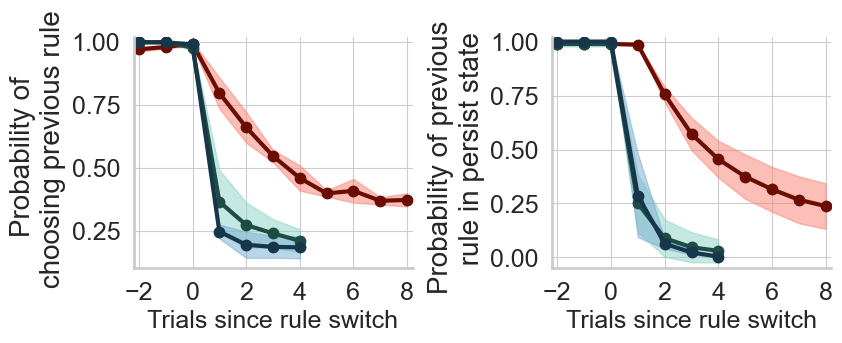

In [17]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(6*1.5,2*1.5))

for metric in range(2):
    meanMonkey = np.mean(monkeyPerseveration[:,:,metric],axis=0)
    stdMonkey = np.std(monkeyPerseveration[:,:,metric],axis=0)
    loMonkey = meanMonkey-stdMonkey
    hiMonkey = meanMonkey+stdMonkey
    ax[metric].plot(xMonkey,meanMonkey,linewidth=3,marker='.',markersize=15,color=speciesDColor[0])
    ax[metric].fill_between(xMonkey,loMonkey,hiMonkey,color=speciesColor[0],alpha=0.5)

    for spInd in range(1, 3): # Species
        idx = np.where(np.array(speciesList) == spInd)[0] - nMonkeys
        meanHuman = np.mean(humanPerseveration[idx,:,metric],axis=0)
        stdHuman = np.std(humanPerseveration[idx,:,metric],axis=0)
        loHuman = meanHuman-stdHuman
        hiHuman = meanHuman+stdHuman
        ax[metric].plot(xHuman,meanHuman,linewidth=3,marker='.',markersize=15,color=speciesDColor[spInd])
        ax[metric].fill_between(xHuman,loHuman,hiHuman,color=speciesColor[spInd],alpha=0.5)

    #######################

    # ax.set_title(subjectNames[metric],fontsize=15,y=1.05)
    ax[metric].set_xticks([-6,-4,-2,0,2,4,6,8])
    ax[metric].set_yticks([0,0.25,0.5,0.75,1])
    # ax.set_xticklabels([-6,-4,-2,0,2,4,6,8])
    if metric == 0:
        ax[metric].set_ylabel('Probability of \n choosing previous rule',fontsize=20)
        ax[metric].set_ylim([0.1,1.02])
    elif metric == 1:
        ax[metric].set_ylabel('Probability of previous \n rule in persist state',fontsize=20)
        ax[metric].set_ylim([-0.05,1.02])

    ax[metric].set_xlim([-2.2,8.2])
    ax[metric].set_xlabel('Trials since rule switch',fontsize=18)

    ax[metric].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[metric].spines[axis].set_linewidth(2)

    ax[metric].spines['right'].set_visible(False)
    ax[metric].spines['top'].set_visible(False)

    ax[metric].set_axisbelow(True)
    # ax[metric].grid(which='major', axis='both')
plt.subplots_adjust(wspace=0.5, 
                    hspace=0.0)

# plt.savefig('persvPersProof.eps', format='eps')

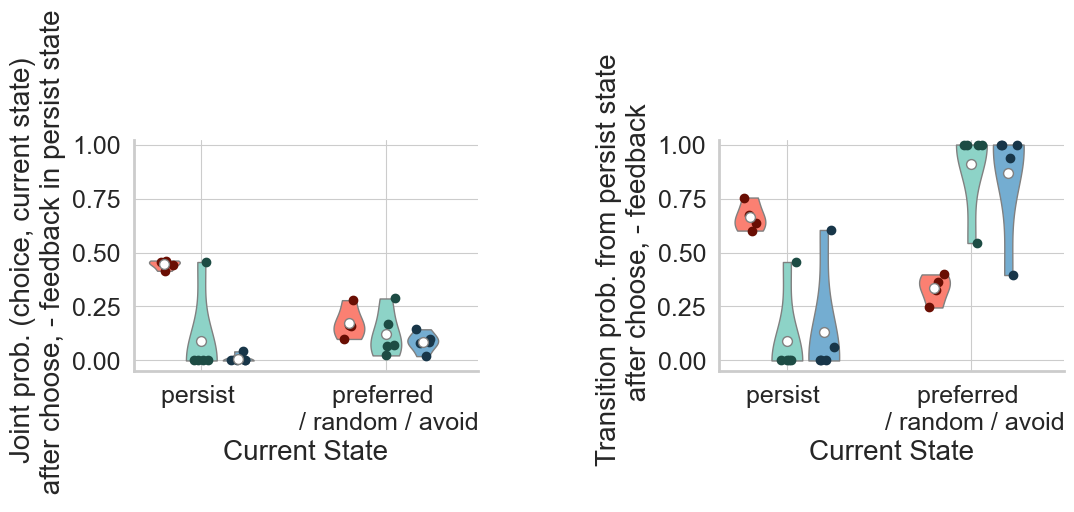

In [3]:
Dat2 = np.zeros((numSubjects,2,2))
for i in range(numSubjects):
    Dat = np.zeros((len(stateNames), 3))
    Dat[:,0] = analysis[i]['categoryAnalysis']['choicePreviousStatePerseveration']['pc_SC']
    Dat[np.isnan(Dat[:,0]),0] = 0
    Dat[:,1] = analysis[i]['categoryAnalysis']['choicePreviousStatePerseveration']['pz_S0C']
    Dat[np.isnan(Dat[:,1]),1] = 0
    Dat[:,2] = np.multiply(Dat[:,0], Dat[:,1])
    Dat2[i,0,0] = Dat[0, 2]
    Dat2[i,0,1] = np.sum(Dat[1:,2])
    Dat2[i,1,0] = Dat[0, 1]
    Dat2[i,1,1] = np.sum(Dat[1:,1])

fig, ax = plt.subplots(ncols=2,nrows=1,sharex=False,sharey=False,figsize=(4*3,3))

vpWidth = 0.5

for k in range(Dat2.shape[1]): # quantities
    for j in range(Dat2.shape[2]): #
        for i in range(3): # species
            idx = np.where(np.array(speciesList) == i)[0]
            data = Dat2[idx,k,j]
            k = k
            vp = ax[k].violinplot(data,[j*3+i*0.6],showextrema=False,widths=vpWidth)

            x = npr.rand(idx.shape[0]) * (vpWidth) * (0.3)
            pm = getPM(idx.shape[0])
            x = np.multiply(x,pm)+j*3+i*0.6+0.025#-0.1#i-0.1 #np.multiply(x,pm) + i

            ax[k].scatter(x,data,color=speciesDColor[i])

            for pc in vp['bodies']:
                pc.set_facecolor(speciesColor[i])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            ax[k].scatter(j*3+i*0.6,np.mean(data),color='white',s=50,edgecolors='gray')

    ax[k].set_ylim([-0.05,1.02])
    ax[k].set_xlim([-0.5,5.1])
    ax[k].set_xticks([0.6,3.6])
    ax[k].set_yticks([0,0.25,0.5,0.75,1])
    ax[k].set_xticklabels(['persist ', 'preferred \n / random / avoid'],fontsize=18)

    if k == 0:
        ax[k].set_ylabel('Joint prob. (choice, current state) \n after choose, - feedback in persist state',fontsize=20)
    elif k == 1:
        ax[k].set_ylabel('Transition prob. from persist state \n after choose, - feedback',fontsize=20)

    ax[k].set_xlabel('Current State',fontsize=20)

    ax[k].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)

plt.subplots_adjust(wspace=0.7, 
                    hspace=0.0)

# plt.savefig('persvCause.eps', format='eps')

In [4]:
def calcBootstrp(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    s = stats.ttest_ind(data1, data2, equal_var=False)
    t = s.statistic

    data1_hat = data1-np.mean(data1) + np.mean(np.concatenate([data1, data2]))
    data2_hat = data2-np.mean(data2) + np.mean(np.concatenate([data1, data2]))
    t_stars = []
    for i in range(10000):
        data1_samp = np.random.choice(data1_hat,size=data1.shape[0])
        data2_samp = np.random.choice(data2_hat,size=data2.shape[0])
        s = stats.ttest_ind(data1_samp, data2_samp, equal_var=False)
        t_stars.append(s.statistic)

    return t, t_stars


In [12]:
mmn = Dat2[:4,1,0]
hmn = Dat2[4:,1,0]
t, t_stars = calcBootstrp(hmn,mmn)
# plt.hist(t_stars,1000)
# plt.xlim([-50,50])
print(np.mean(t_stars<=t))

[0.60154525 0.67343173 0.63444268 0.75465216 0.         0.
 0.         0.         0.45604396 0.         0.         0.06315789
 0.         0.6043956 ]


/var/folders/d0/w_19qmbx12q36d9zs46hfymm0000gn/T/ipykernel_83905/4068514626.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = stats.ttest_ind(data1_samp, data2_samp, equal_var=False)


0.1157


In [29]:
pc_S0 = np.zeros([numSubjects])

for i in range(numSubjects):
    pc_S0[i] = analysis[i]['categoryAnalysis']['rulePersistChoiceProbability']



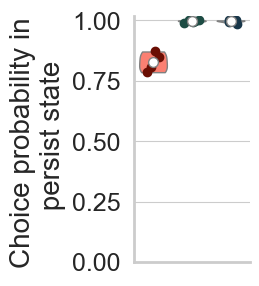

In [30]:
fig, ax = plt.subplots(figsize=(1.5,3.2))

vpWidth = 0.5

for i in range(3): # species
    idx = np.where(np.array(speciesList) == i)[0]
    data = pc_S0[idx]
    vp = ax.violinplot(data,[i*0.7],showextrema=False,widths=vpWidth)
    
    x = npr.rand(idx.shape[0]) * (vpWidth) * (0.3)
    pm = getPM(idx.shape[0])
    x = np.multiply(x,pm) + i*0.7
    
    ax.scatter(x,data,color=speciesDColor[i])

    for pc in vp['bodies']:
        pc.set_facecolor(speciesColor[i])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)
        
    ax.scatter(i*0.7,np.mean(data),color='white',s=50,edgecolors='gray')

ax.set_ylim([0,1.02])
ax.set_xlim([-0.35,1.75])
ax.set_xticks([])
ax.set_yticks([0,0.25,0.5,0.75,1])
# ax.set_xticklabels(['Monkeys','Humans'],fontsize=20)
ax.set_ylabel('Choice probability in \n persist state',fontsize=20)
ax.tick_params(axis='x',labelsize= 18,direction='out',width=2,length=6)
ax.tick_params(axis='y',labelsize= 18,direction='out',width=2,length=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
# fig.text(0.51, -0.13, '* feature was in persist state \n on previous trial', ha='center', size=12)

# plt.savefig('longProofPersProb.eps', format='eps')

In [34]:
Lc5 = []
Lc5Sim = []

for i in range(numSubjects):
    Lc5.append(analysis[i]['categoryAnalysis']['LCategory'][5,:])
    Lc5Sim.append(analysis[i]['categoryAnalysis']['rulePersistTrialsToCriteria'])
# maybe this should be from analysis[i]['choiceStats']['pc_S_mdl'][0]    


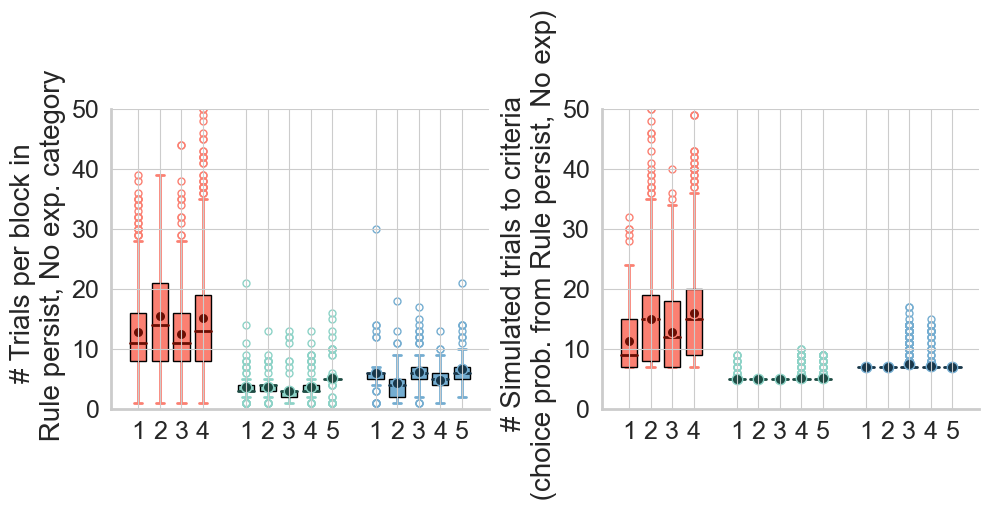

In [33]:
# fig, ax = plt.subplots(figsize=(7,4))

fig, ax = plt.subplots(ncols=2,nrows=1,sharex=False,sharey=False,figsize=(4*2*1.4,3*1.3))


for p in range(2):
    xPos = []

    pos = -0.8*2
    for spInd in range(3):
        idx = np.where(np.array(speciesList) == spInd)[0]

        prop1 = dict(color=speciesColor[spInd],linewidth=2)
        prop2 = dict(color=speciesDColor[spInd],linewidth=2)
        prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)
        prop4 = dict(markerfacecolor=speciesDColor[spInd],
                     markeredgecolor=speciesColor[spInd],marker='.',markersize=15)

        pos += 0.8
        for i in idx:

            pos += 0.8

            xPos.append(pos)
            if p == 0:
                data = Lc5[i]
            else:
                data = Lc5Sim[i]
            fidx = np.where(data > 0)[0]
            bp = ax[p].boxplot(data[fidx],positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,
                            capprops=prop1,flierprops=prop3,zorder=0,showmeans=True,meanprops=prop4)

            bp['boxes'][0].set_facecolor(speciesColor[spInd])

    ax[p].set_xlim([xPos[0]-1,xPos[-1]+1])
    ax[p].set_ylim([0,50])
    ax[p].set_xticks(xPos)
    ax[p].set_xticklabels(subjectNames,fontsize=10) #,rotation=30

#     ax[p].text(1.5, -7, 'Monkeys', ha='center', size=20)
#     ax[p].text(6.8, -7, 'Humans', ha='center', size=20)
    # fig.text(0.5, -0.25, 'N = '+str(Lc5Sim[0].shape[0])+' simulations', ha='center', size=12)

    if p == 0:
        ax[p].set_ylabel('# Trials per block in \n Rule persist, No exp. category',fontsize=20)
    else:
        ax[p].set_ylabel('# Simulated trials to criteria \n (choice prob. from Rule persist, No exp)',fontsize=20)


    ax[p].tick_params(axis='both',direction='out',width=2, length=6)
    ax[p].tick_params(axis='x',length=5,labelsize=18)
    ax[p].tick_params(axis='y',length=5,labelsize=18)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[p].spines[axis].set_linewidth(2)

    ax[p].spines['right'].set_visible(False)
    ax[p].spines['top'].set_visible(False)

    ax[p].set_axisbelow(True)
    
plt.subplots_adjust(wspace=0.3, 
                    hspace=0.0)
# plt.savefig('longProofSim.eps', format='eps')
plt.show()